# Tutorial 2: Dealing with large datasets with FastEstimator
_____

In Tutorial 1, we introduced our 3 main APIs and general workflow of a deep learning task using FastEstimator:  `Pipeline` -> `Network` -> `Estimator`. Then we used in-memory data for training.  
*__But what if the dataset size was too big to fit in memory? Imagine data is the size of ImageNet?__*

The short answer is: __the user will use one more API to use in disk data for training: `RecordWriter`__, such that the overall workflow becomes:   
`RecordWriter` -> `Pipeline` -> `Network` -> `Estimator`. In this tutorial, we are going to show you how to do in-disk data training in FastEstimator.

## Before we start:

Two things are required regarding in-disk data : 
* Data files, obviously :)
* A csv file that describes the data (prepare two csv files if you have a separate validation set)

In the csv file, the rows of csv represent different examples and columns represent different features within example. For example, for a classification task, a csv may look like this:

| image  | label  |
|---|---|
|/data/image1.png   | 0  |
|/data/image2.png   |  1 |
|/data/image3.png | 0  |
|... | .  |

The csv of a multi-mask segmentation task may look like this:

| img  | msk1  | msk2  |
|---|---|---|
|/data/image1.png   | /maska/mask1.png  |/maskb/mask1.png|
|/data/image2.png   |  /maska/mask2.png |/maskb/mask2.png|
|/data/image3.png | /maska/mask3.png  |/maskb/mask3.png|
|... | ...  |...|


Please keep in mind that, there is no restriction on the data folder structures, number of features or name of features.  

Now, let's generate some in-disk data for this tutorial!

## Step 0: Get the paths to the csv files

For this example, we will use the function `load_data` from MNIST dataset to download the dataset and get the paths to the above-mentioned csv files for training, evaluation and to the data directory. 
You just have to use the paths for your specific case.

In [1]:
from fastestimator.dataset.mnist import load_data

train_csv, eval_csv, folder_path = load_data()
print("training csv path is {}".format(train_csv))
print("evaluation csv path is {}".format(eval_csv))
print("mnist image path is {}".format(folder_path))

training csv path is /tmp/.fe/Mnist/train.csv
evaluation csv path is /tmp/.fe/Mnist/eval.csv
mnist image path is /tmp/.fe/Mnist


Let's take a look at the csv file and image file.

In [2]:
import pandas as pd
df_train = pd.read_csv(train_csv)
df_train.head()

,x,y
0,image/train_0.png,5
1,image/train_1.png,0
2,image/train_2.png,4
3,image/train_3.png,1
4,image/train_4.png,9


ground truth of image is 0


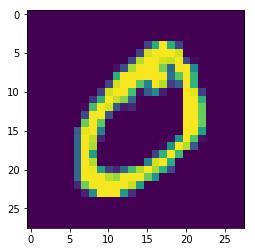

In [3]:
import matplotlib.pyplot as plt
import os
img = plt.imread(os.path.join(folder_path, df_train["x"][1]))
plt.imshow(img)
print("ground truth of image is {}".format(df_train["y"][1]))

## Step 1: RecordWriter


In FastEstimator, we convert user's in-disk data to TFRecord for the best training speed. The RecordWriter API takes care of it. 

You will have to specify : 

- `save_dir` : the path to write the record.    
   
   
- `train_data` : can either be a csv path or a dictionary like the one used in tutorial 1.  
 
 
- `validation_data` (optional) : it can take all input formats of `train_data`. In addition, `validation_data` can also take a floating point number between 0 to 1 which indicates the validation split ratio, then validation data will be randomly sampled from training data.  
 
 
- `ops`: before converting data to TFRecord, users can apply a series of propcoessing tasks to the data in `ops` argument, we will talk about them in detail in tutorial 3.

In [4]:
from fastestimator.util import RecordWriter
from fastestimator.op.numpyop import ImageReader
import fastestimator as fe
import tempfile

# We simply create a RecordWriter will all required arguments. 
writer = RecordWriter(save_dir=os.path.join(folder_path, "FEdata"),
                         train_data=train_csv,
                         validation_data=eval_csv,
                         ops=ImageReader(inputs="x", parent_path=folder_path, outputs="x", grey_scale=True))

## Step 2: Pipeline -> Network -> Estimator (see tutorial 1 for details)

In [5]:
from fastestimator.op.tensorop import Minmax
from fastestimator.architecture import LeNet
from fastestimator.op.tensorop.model import ModelOp
from fastestimator.op.tensorop.loss import SparseCategoricalCrossentropy

# Pipeline creation
pipeline = fe.Pipeline(batch_size=32, data=writer, ops=Minmax(inputs="x", outputs="x"))

# Model and network definition
model = fe.build(model_def=LeNet, model_name="lenet", optimizer="adam", loss_name="loss")
network = fe.Network(ops=[ModelOp(inputs="x", model=model, outputs="y_pred"), 
                          SparseCategoricalCrossentropy(y_pred="y_pred", y_true="y", outputs="loss")])

# Estimator definition
estimator = fe.Estimator(network=network, pipeline=pipeline, epochs=2)

## Step 3: Start training

In [6]:
# Launch the training!
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Saving tfrecord to /tmp/.fe/Mnist/FEdata
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 25311.16 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 16474.48 record/sec
FastEstimator: Converting Train TFRecords 15.0%, Speed: 12341.98 record/sec
FastEstimator: Converting Train TFRecords 20.0%, Speed: 11620.45 record/sec
FastEstimator: Converting Train TFRecords 25.0%, Speed: 11131.52 record/sec
FastEstimator: Converting Train TFRecords 30.0%, Speed:

___
## Key take-aways:

As mentioned in tutorial 1, the preprocessing in the `RecordWriter` is a place for "once-for-all" type preprocessing. If a preprocessing function only needs to be done once (e,g, Resize and Rescale), then it is recommended to put them in `RecordWriter`. By doing this you can reduce the amount of computation needed during training and thereby train faster.

>Now, let's summarize the **conceptual workflow** in FastEstimator for any deep learning task:
>0. _[Optional]_ Do I have in-disk data or want to apply some preprocessing once and for all? _-> Express this in `RecordWriter`_
>1. How do I want my data to be processed during the training? _-> Express this in `Pipeline`_
>2. How do I want my network architecture and loss to be defined? what are the connections between networks if there are multiple of them? _-> Express this in `Network`_
>3. How long do I train the model? what do I need during training loop? _-> Express this in `Estimator`_